# Time Series Forecasting: Simple Methods and LSTM

### A Comparative Study on Forecasting Techniques

---

This Jupyter Notebook demonstrates two popular approaches to time series forecasting using climate data from Delhi:

1. **Simple Moving Average Forecasting**: A basic yet effective method to smooth time series data and make short-term forecasts.
2. **LSTM (Long Short-Term Memory) Neural Networks**: A deep learning approach well-suited for time series data with long-term dependencies.

### Data Sources:
- `DailyDelhiClimateTrain.csv`: Contains historical data used for training the model.
- `DailyDelhiClimateTest.csv`: Contains the data used for testing the model's forecasting performance.

### Features:
- **Mean Temperature**
- **Humidity**
- **Wind Speed**
- **Mean Pressure**

---

In this notebook, we will visualize the forecasting results and compare the performance of the simple moving average method and the more advanced LSTM neural network for time series forecasting.


In [51]:
#!pip install seaborn --upgrade

In [64]:
#Libraries 
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt 

import plotly.express as px
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go
import plotly.io as pio 
from plotly.subplots import make_subplots

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
df = pd.read_csv("./data/DailyDelhiClimateTest.csv", parse_dates=True , index_col="date")
df = pd.read_csv("./data/DailyDelhiClimateTrain.csv", parse_dates=True , index_col="date")
df

meantemp    humidity  wind_speed  meanpressure
date                                                       
2013-01-01  10.000000   84.500000    0.000000   1015.666667
2013-01-02   7.400000   92.000000    2.980000   1017.800000
2013-01-03   7.166667   87.000000    4.633333   1018.666667
2013-01-04   8.666667   71.333333    1.233333   1017.166667
2013-01-05   6.000000   86.833333    3.700000   1016.500000
...               ...         ...         ...           ...
2016-12-28  17.217391   68.043478    3.547826   1015.565217
2016-12-29  15.238095   87.857143    6.000000   1016.904762
2016-12-30  14.095238   89.666667    6.266667   1017.904762
2016-12-31  15.052632   87.000000    7.325000   1016.100000
2017-01-01  10.000000  100.000000    0.000000   1016.000000

[1462 rows x 4 columns]

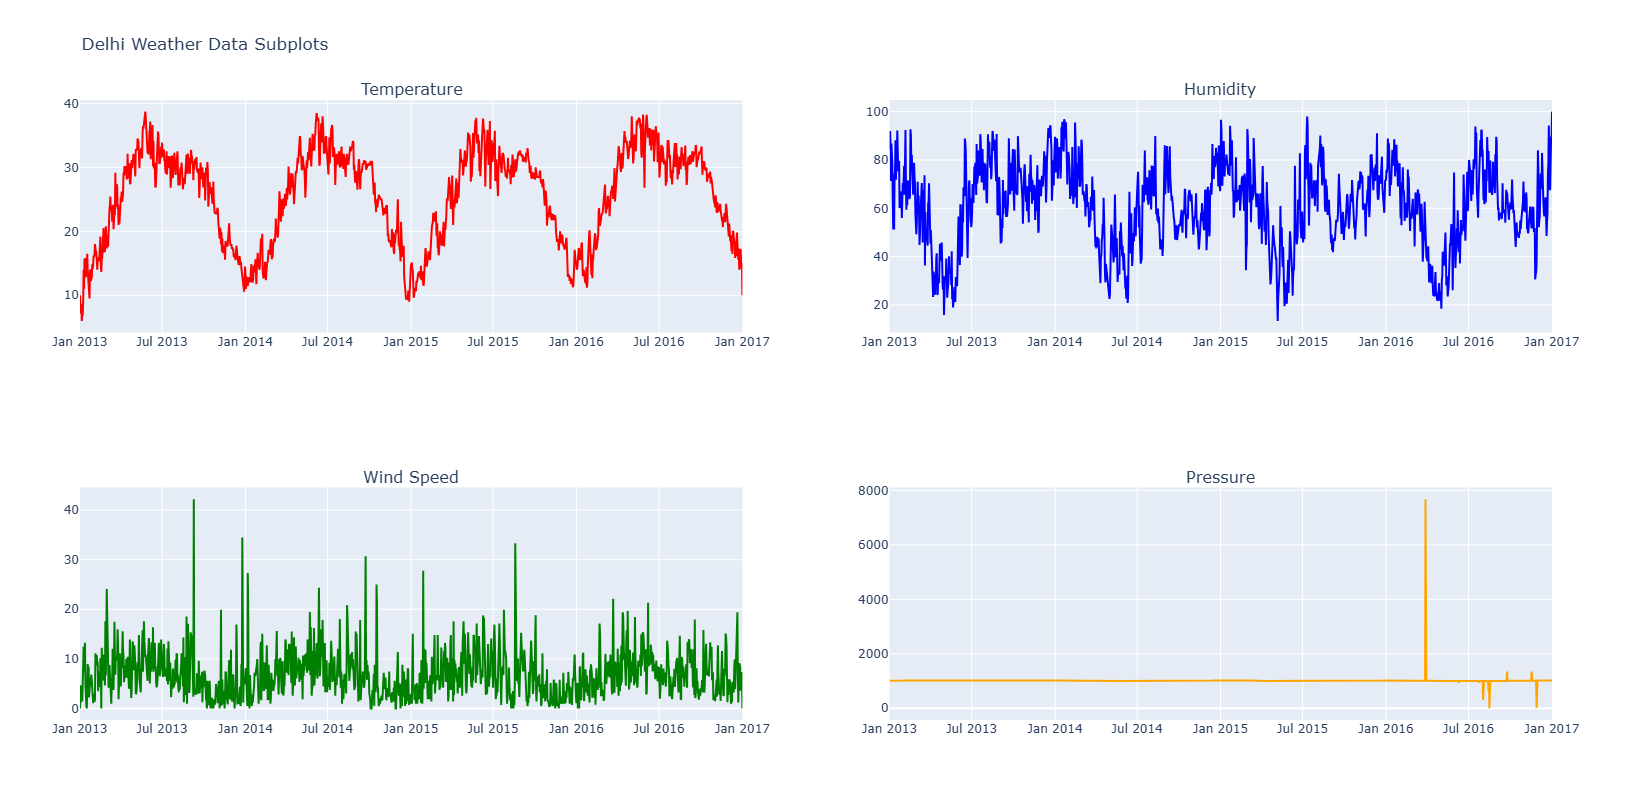

In [3]:
fig = make_subplots(rows=2, cols=2, subplot_titles=("Temperature", "Humidity", "Wind Speed", "Pressure"))

# Temperature plot
fig.add_trace(
    go.Scatter(x=df.index, y=df['meantemp'], mode='lines', name='Temperature', line=dict(color='red')),
    row=1, col=1)

# Humidity plot
fig.add_trace(
    go.Scatter(x=df.index, y=df['humidity'], mode='lines', name='Humidity', line=dict(color='blue')),
    row=1, col=2)

# Pressure plot
fig.add_trace(
    go.Scatter(x=df.index, y=df['wind_speed'], mode='lines', name='Wind Speed', line=dict(color='green')),
    row=2, col=1)

# Wind Speed plot
fig.add_trace(
    go.Scatter(x=df.index, y=df['meanpressure'], mode='lines', name='Pressure', line=dict(color='orange')),
    row=2, col=2)

# Update layout
fig.update_layout(
    title='Delhi Weather Data Subplots',
    height=800,
    width=1100,
    showlegend=False  # Set to False if you don't want a shared legend
)
# Display the plot
pio.show(fig)

In [7]:
df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].corr()

meantemp  humidity  wind_speed  meanpressure
meantemp      1.000000 -0.571951    0.306468     -0.038818
humidity     -0.571951  1.000000   -0.373972      0.001734
wind_speed    0.306468 -0.373972    1.000000     -0.020670
meanpressure -0.038818  0.001734   -0.020670      1.000000

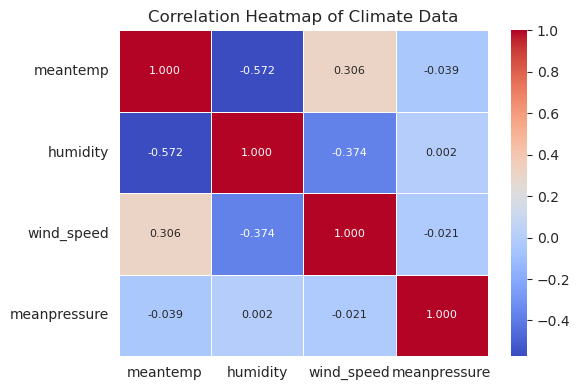

In [9]:
plt.figure(figsize=(6, 4))
sns.heatmap(df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].corr(), 
            annot=True, 
            cmap='coolwarm', 
            fmt='.3f', 
            annot_kws={"size": 8},
            square=False, linewidths=0.5)
plt.title('Correlation Heatmap of Climate Data')
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

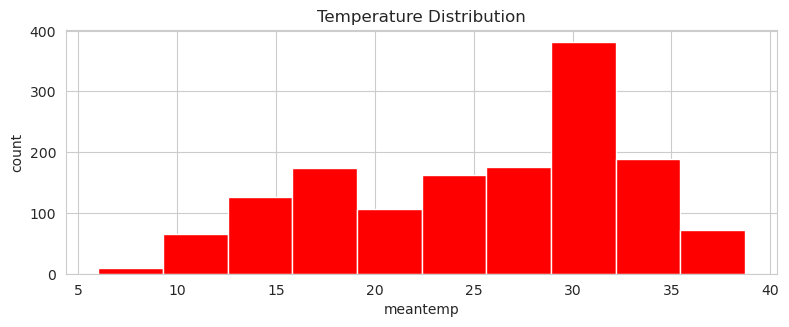

In [11]:
plt.figure(figsize=(8, 12))
plt.subplot(4, 1, 1)
plt.hist(df['meantemp'], color='red')
plt.xlabel('meantemp')
plt.ylabel('count')
plt.title('Temperature Distribution')
plt.tight_layout()
plt.show()

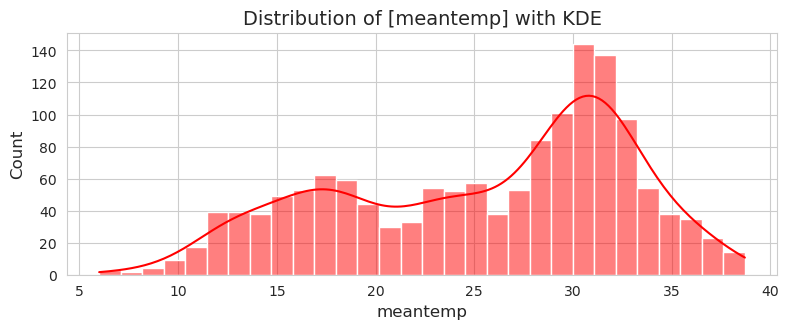

In [29]:
selected_column='meantemp'
#selected_column='meanpressure'

# Create the figure
plt.figure(figsize=(8, 12))

# Temperature Distribution with histogram and KDE
plt.subplot(4, 1, 1)
sns.histplot(df[selected_column], kde=True, color='red', bins=30)  # Adding KDE and increasing bins
plt.xlabel(selected_column, fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of ['+selected_column+'] with KDE', fontsize=14)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

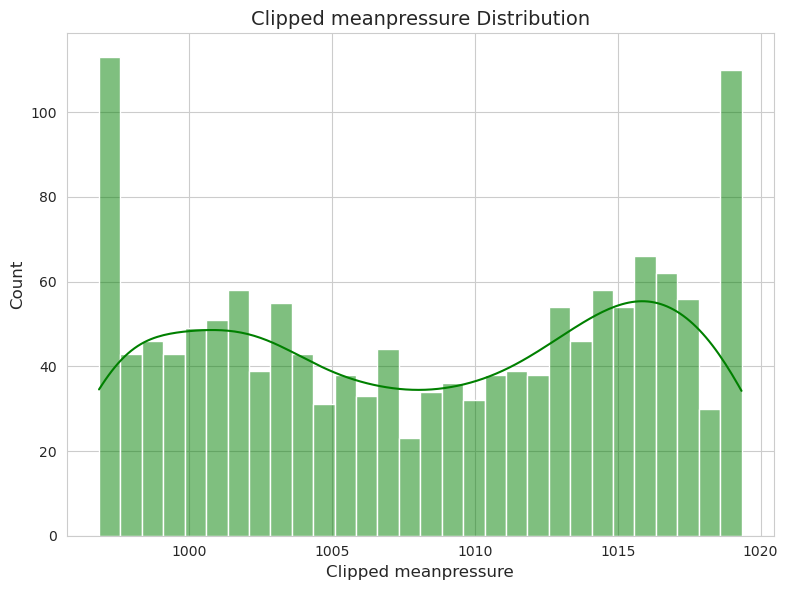

In [31]:
# Define limits for clipping outliers
lower_bound = df['meanpressure'].quantile(0.05)
upper_bound = df['meanpressure'].quantile(0.95)

# Clip the outliers
df['clipped_meanpressure'] = df['meanpressure'].clip(lower=lower_bound, upper=upper_bound)

# Plot the clipped distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['clipped_meanpressure'], kde=True, color='green', bins=30)
plt.xlabel('Clipped meanpressure', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Clipped meanpressure Distribution', fontsize=14)
plt.tight_layout()

plt.show()

## Simple Method: Moving Average Forecasting

In this example, we will forecast the `meantemp` column using a simple moving average approach.

In [41]:
# Load the training and testing datasets
train_df = pd.read_csv("./data/DailyDelhiClimateTrain.csv", parse_dates=True, index_col="date")
test_df = pd.read_csv("./data/DailyDelhiClimateTest.csv", parse_dates=True, index_col="date")

In [43]:
# Simple moving average forecast with a window of 7 days
window_size = 7
train_df['moving_avg'] = train_df['meantemp'].rolling(window=window_size).mean()

# Forecasting for the test set (we use the last known value from training to extend the forecast)
last_train_value = train_df['moving_avg'].dropna().iloc[-1]
test_df['moving_avg_forecast'] = last_train_value

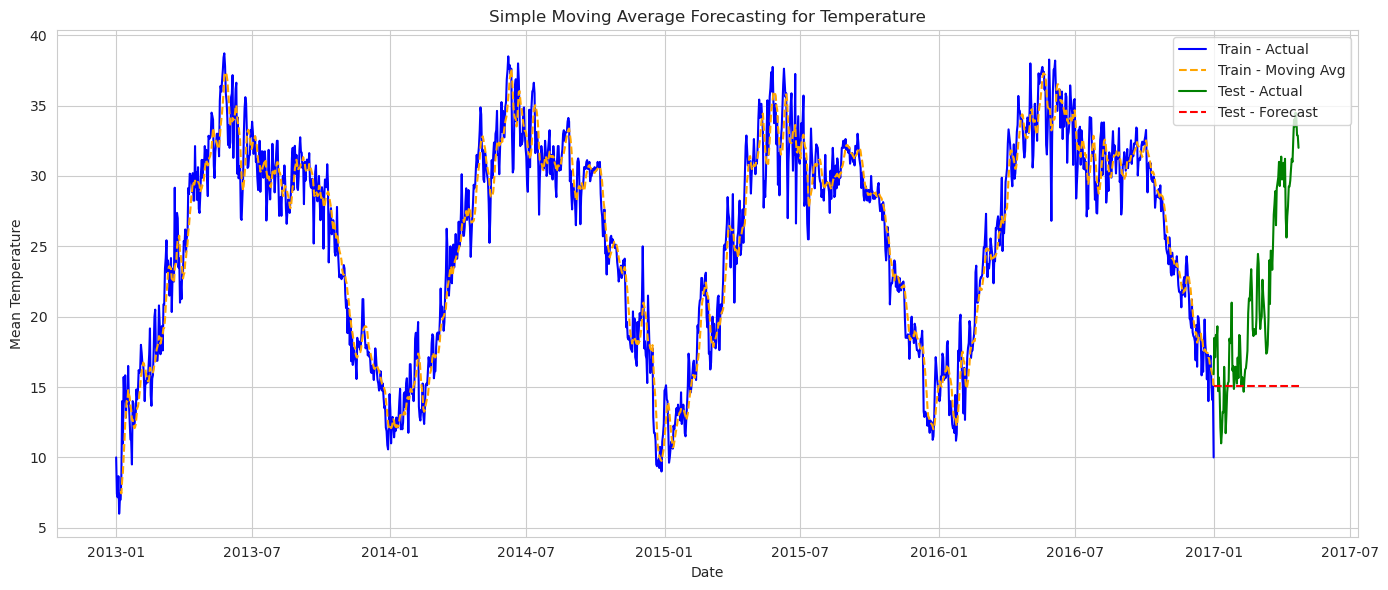

In [45]:
# Plotting the actual vs forecast
plt.figure(figsize=(14, 6))
plt.plot(train_df.index, train_df['meantemp'], label='Train - Actual', color='blue')
plt.plot(train_df.index, train_df['moving_avg'], label='Train - Moving Avg', color='orange', linestyle='--')
plt.plot(test_df.index, test_df['meantemp'], label='Test - Actual', color='green')
plt.plot(test_df.index, test_df['moving_avg_forecast'], label='Test - Forecast', color='red', linestyle='--')

plt.title('Simple Moving Average Forecasting for Temperature')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Since our data has strong seasonality, the **Simple Moving Average method** won't capture the seasonal pattern effectively, as it only provides a smoothed, flat forecast based on past values. For time series data with seasonality, a more appropriate approach would be to use methods specifically designed for seasonal data. 

## Seasonal Naive Forecasting
This method is useful when seasonality is strong and easy to detect. The Seasonal Naive method predicts the next value based on the last known value from the same season in previous cycles. This method assumes that seasonal patterns repeat.

In [52]:
# Load the training and testing datasets
train_df = pd.read_csv("./data/DailyDelhiClimateTrain.csv", parse_dates=True, index_col="date")
test_df = pd.read_csv("./data/DailyDelhiClimateTest.csv", parse_dates=True, index_col="date")

In [58]:
# Seasonal Naive Forecast: Assume the forecast for the test period is the same as the previous year's data
seasonal_period = 365  # Assuming daily data with yearly seasonality

# Use the last seasonal_period days from training to forecast the test set
seasonal_naive_forecast = train_df['meantemp'].iloc[-seasonal_period:].values

# Repeat the forecast values to match the length of the test set
forecast_length = len(test_df)
seasonal_naive_forecast = seasonal_naive_forecast[:forecast_length]

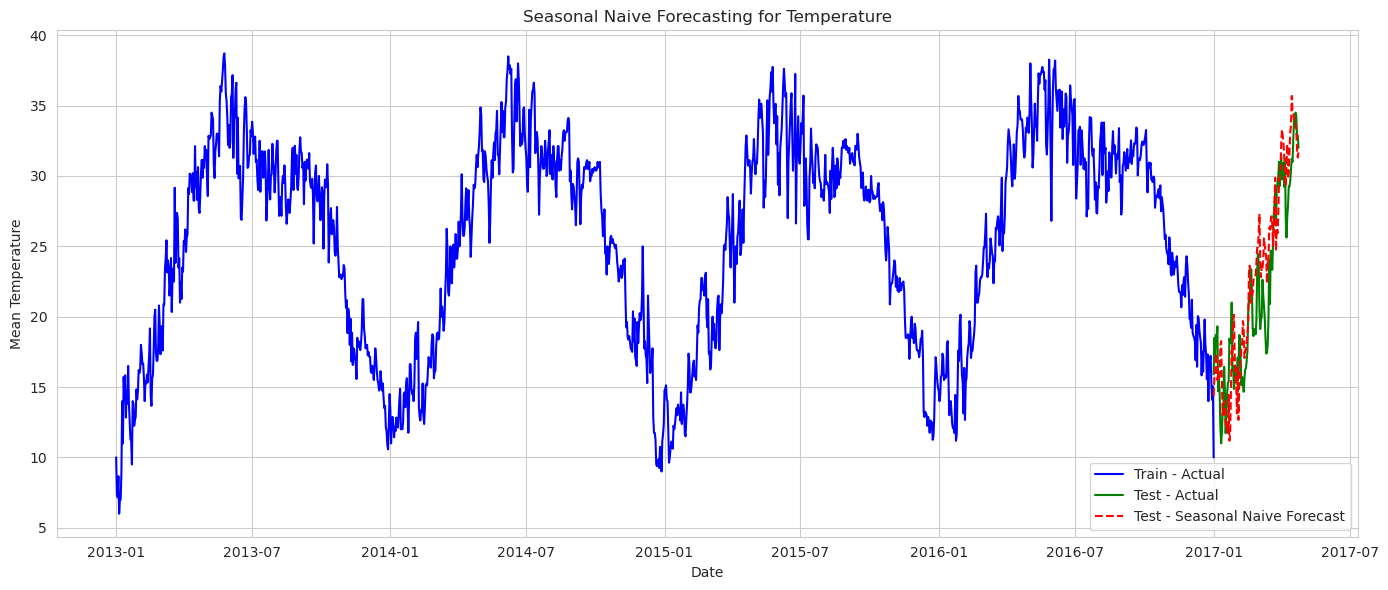

In [68]:
# Plot the results
plt.figure(figsize=(14, 6))

# Plot the actual values from the training and test sets
plt.plot(train_df.index, train_df['meantemp'], label='Train - Actual', color='blue')
plt.plot(test_df.index, test_df['meantemp'], label='Test - Actual', color='green')

# Plot the seasonal naive forecast
plt.plot(test_df.index, seasonal_naive_forecast, label='Test - Seasonal Naive Forecast', color='red', linestyle='--')

plt.title('Seasonal Naive Forecasting for Temperature')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Key Points:

- **Seasonal Naive Method**: We assume that the temperature pattern repeats every year, so we forecast the test set using the last year of data from the training set.
- **Visualization**: The plot will show how this method captures the seasonal variation by repeating the last observed seasonal pattern.

## Seasonal Decomposition + Exponential Smoothing (ETS)

You can decompose the time series into seasonal, trend, and residual components and then apply exponential smoothing to forecast the trend and seasonal components separately.

In [94]:
# Load the training and testing datasets
train_df = pd.read_csv("./data/DailyDelhiClimateTrain.csv", parse_dates=True, index_col="date")
test_df = pd.read_csv("./data/DailyDelhiClimateTest.csv", parse_dates=True, index_col="date")

# Ensure the data has monthly frequency
train_df = train_df.asfreq('D')  # 'D' = Day
test_df = test_df.asfreq('D')

In [96]:
# STL Decomposition on training data with seasonal window set to 365 (for daily data)
stl = STL(train_df['meantemp'], seasonal=365)
result = stl.fit()

# Apply Exponential Smoothing to forecast the trend component
trend_model = ExponentialSmoothing(result.trend.dropna(), trend='add', seasonal=None).fit()
trend_forecast = trend_model.forecast(steps=len(test_df))

# Extract the seasonal component from the last year of the training set
seasonal_component = result.seasonal[-365:]

# Repeat the seasonal pattern to match the length of the test set
seasonal_forecast = np.tile(seasonal_component, int(np.ceil(len(test_df) / len(seasonal_component))))[:len(test_df)]

# Combine the trend and seasonal forecast to get the final forecast
final_forecast = trend_forecast + seasonal_forecast

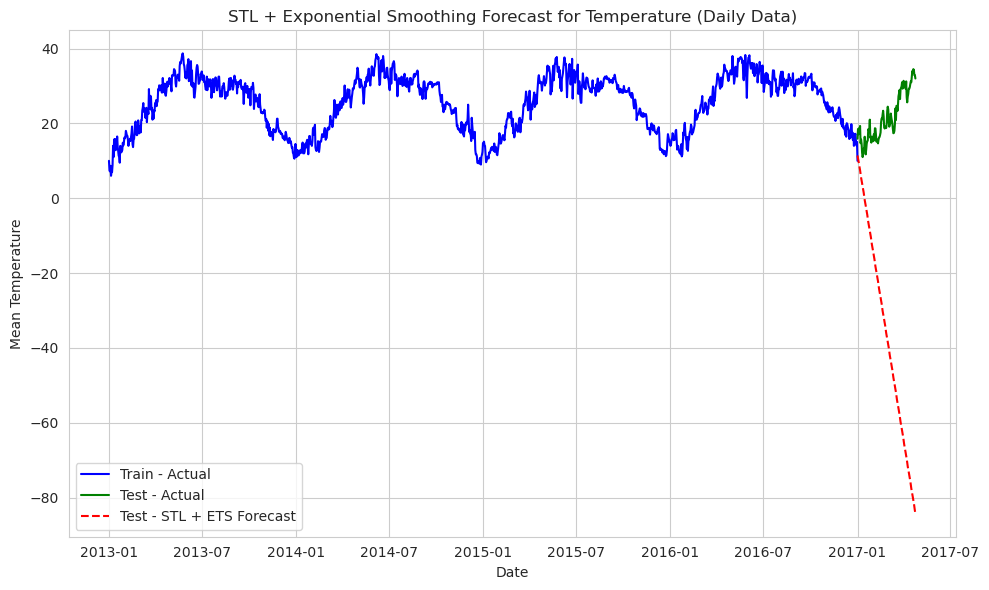

In [98]:
# Plot the results
plt.figure(figsize=(10, 6))

# Plot actual values from the training and test sets
plt.plot(train_df.index, train_df['meantemp'], label='Train - Actual', color='blue')
plt.plot(test_df.index, test_df['meantemp'], label='Test - Actual', color='green')

# Plot the final forecast
plt.plot(test_df.index, final_forecast, label='Test - STL + ETS Forecast', color='red', linestyle='--')

plt.title('STL + Exponential Smoothing Forecast for Temperature (Daily Data)')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Using LSTM for Time Series Forecasting

In this example, we will use an LSTM neural network to forecast the `meantemp`. LSTMs are well-suited for sequential data like time series.

Step-by-Step Code for LSTM Forecasting:

In [100]:
# Load the training and testing datasets
train_df = pd.read_csv("./data/DailyDelhiClimateTrain.csv", parse_dates=True, index_col="date")
test_df = pd.read_csv("./data/DailyDelhiClimateTest.csv", parse_dates=True, index_col="date")

In [102]:
# Prepare the data (using only meantemp for simplicity)
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[['meantemp']])
test_scaled = scaler.transform(test_df[['meantemp']])


In [104]:
# Prepare the data for LSTM (input sequences)
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 7  # Using a 7-day sequence
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16)

# Make predictions on the test set
predictions = model.predict(X_test)

# Inverse transform the predictions to original scale
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

Epoch 1/10
91/91 [==============================] - 4s 19ms/step - loss: 0.0485
Epoch 2/10
91/91 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch 3/10
91/91 [==============================] - 3s 28ms/step - loss: 0.0045
Epoch 4/10
91/91 [==============================] - 1s 14ms/step - loss: 0.0046
Epoch 5/10
91/91 [==============================] - 1s 7ms/step - loss: 0.0043
Epoch 6/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0043
Epoch 7/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0043
Epoch 8/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0041
Epoch 9/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0041
Epoch 10/10
4/4 [==============================] - 0s 5ms/step


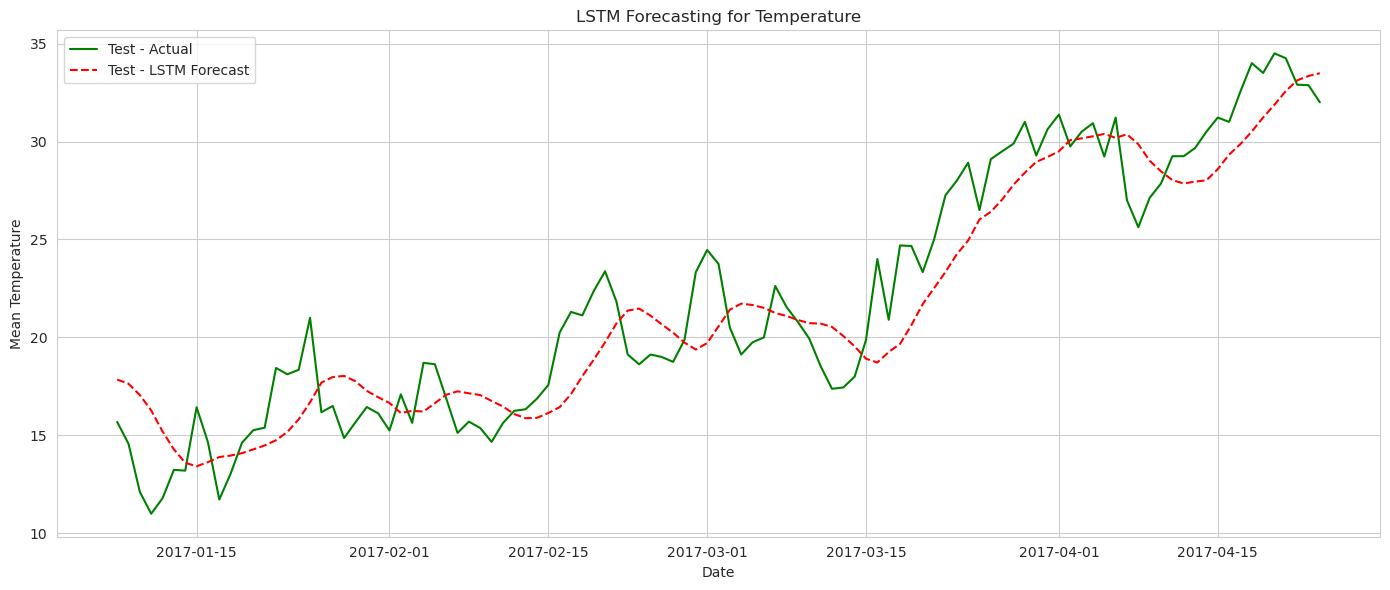

In [106]:
# Plotting the results
plt.figure(figsize=(14, 6))
plt.plot(test_df.index[seq_length:], y_test_rescaled, label='Test - Actual', color='green')
plt.plot(test_df.index[seq_length:], predictions, label='Test - LSTM Forecast', color='red', linestyle='--')

plt.title('LSTM Forecasting for Temperature')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [108]:
# To plot the training set with LSTM forecast, create the LSTM forecast for training data
train_predictions = model.predict(X_train)
train_predictions_rescaled = scaler.inverse_transform(train_predictions)

46/46 [==============================] - 0s 4ms/step


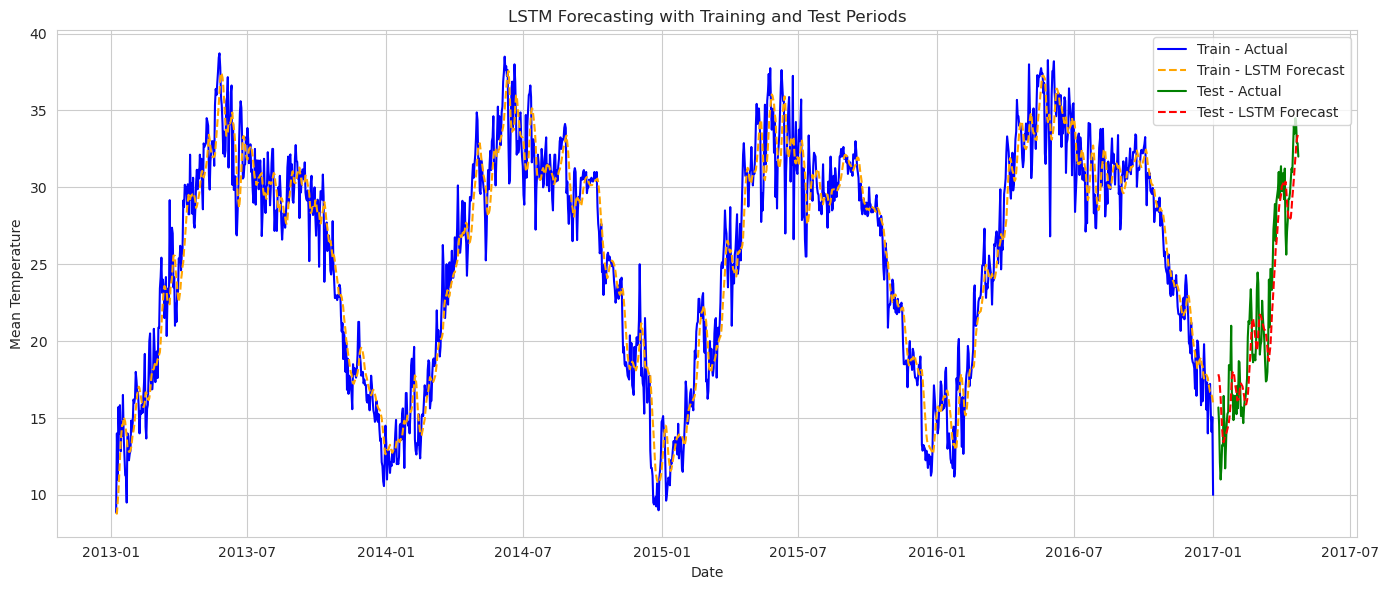

In [110]:
# Create a combined plot to show the training and test period
plt.figure(figsize=(14, 6))

# Plot actual values from the training set
plt.plot(train_df.index[seq_length:], scaler.inverse_transform(y_train.reshape(-1, 1)), label='Train - Actual', color='blue')

# Plot the LSTM forecast for the training period
plt.plot(train_df.index[seq_length:], train_predictions_rescaled, label='Train - LSTM Forecast', color='orange', linestyle='--')

# Plot actual values from the test set
plt.plot(test_df.index[seq_length:], y_test_rescaled, label='Test - Actual', color='green')

# Plot the LSTM forecast for the test period
plt.plot(test_df.index[seq_length:], predictions, label='Test - LSTM Forecast', color='red', linestyle='--')

plt.title('LSTM Forecasting with Training and Test Periods')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Key Points:

- **Data Preprocessing**: The data is normalized using MinMaxScaler for better performance of the LSTM. The sequences are generated by splitting the data into input-output pairs (with a sequence length of 7 days).
- **LSTM Model**: The LSTM model is built using `keras`, and trained on the training data for 10 epochs.
- **Visualization**: The plot shows the actual values for the test dataset compared to the LSTM forecasted values.


## Final Thoughts:

- The simple moving average method is easy to explain and implement, though it is limited in its forecasting capability.
- he LSTM method offers more predictive power for time series with sequential dependencies but requires more computational resources and preprocessing.

These two examples should help you understand the basics of time series forecasting using both simple and advanced methods, while also providing them with clear visualizations to compare the effectiveness of each approach.